# Importing neccessary libraries and datasets

In [ ]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
   ━━

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
import torch
import re
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from nltk.corpus import wordnet  # For accessing synonyms
import nlpaug.augmenter.word as naw  # Library for text augmentation
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
print(f"Number of rows in the dataset: {len(df)}")
print(df.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Number of rows in the dataset: 16000
                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


In [ ]:
# Lowercase
df['text'] = df['text'].apply(lambda x: x.lower())
# Removing punctuation
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Removing special characters
df['text'] = df['text'].apply(lambda x: re.sub(r'\d+', '', x))
# Handle missing values
df.dropna(subset=['text', 'label'], inplace=True)


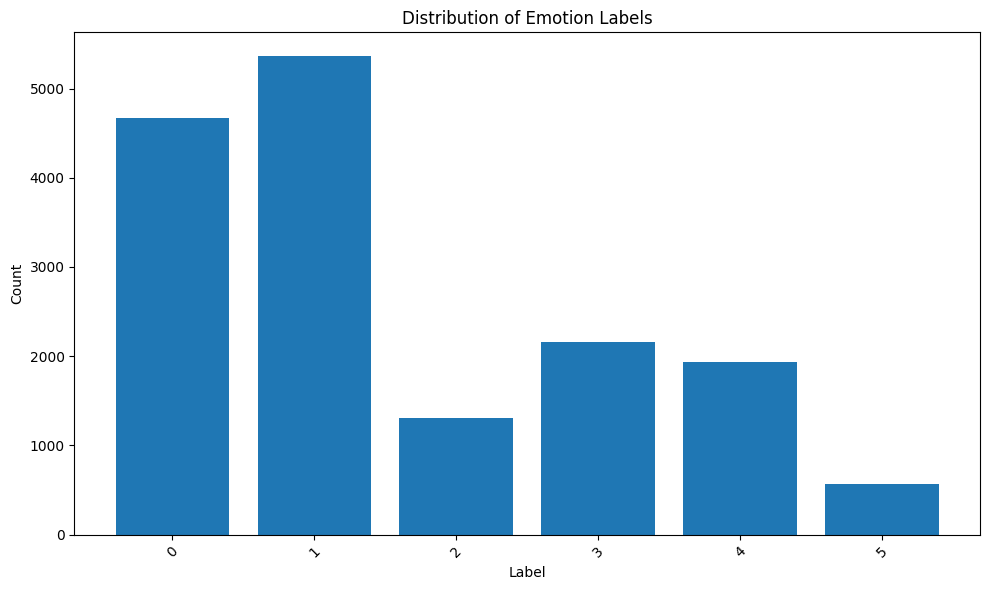

In [ ]:
# Create bar chart of label distribution
label_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values)
plt.title('Distribution of Emotion Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
def augment_text(text):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(text)[0]
    return augmented_text

# Create balanced dataset with augmentation
balanced_dfs = []
max_size = df['label'].value_counts().max()

for label in df['label'].unique():
    class_df = df[df['label'] == label]
    if len(class_df) < max_size:
        # Calculate how many augmented samples we need
        n_aug = max_size - len(class_df)
        # Original samples
        balanced_dfs.append(class_df)

        # Augmented samples
        aug_df = class_df.sample(n=n_aug, replace=True)
        aug_df['text'] = aug_df['text'].apply(augment_text)
        balanced_dfs.append(aug_df)
    else:
        balanced_dfs.append(class_df)

balanced_df = pd.concat(balanced_dfs, ignore_index=True)
dataset = Dataset.from_pandas(balanced_df)

In [ ]:
# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=31)

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Split into train and validation sets
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2)
tokenized_datasets = {
    'train': tokenized_datasets['train'],
    'validation': tokenized_datasets['test']
}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/32172 [00:00<?, ? examples/s]

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
)

# Fine-tune the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.359800,0.354244
2,0.209500,0.319120


TrainOutput(global_step=6436, training_loss=0.38368695474248854, metrics={'train_runtime': 420.0741, 'train_samples_per_second': 122.536, 'train_steps_per_second': 15.321, 'total_flos': 412875999407736.0, 'train_loss': 0.38368695474248854, 'epoch': 2.0})

In [ ]:
# Create a zip file of the essential files
!zip -r emotion_detection_model.zip ./results/checkpoint-6436/config.json ./results/checkpoint-6436/model.safetensors ./results/checkpoint-6436/training_args.bin

# This will create a downloadable zip file
from google.colab import files
files.download('emotion_detection_model.zip')

  adding: results/checkpoint-6436/config.json (deflated 52%)
  adding: results/checkpoint-6436/model.safetensors (deflated 8%)
  adding: results/checkpoint-6436/training_args.bin (deflated 51%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>